# Counting Events in HDF5 data
<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator
import oskar

## Import Data

In [2]:
rid = '20160311_191136'
h5 = oskar.h5_data(rid)         # data
out_dire = h5.out_dire("Count") # output

In [3]:
# data
ftype = 'CH_A1'
squid = 4
trace, info = h5.load_array(squid, ftype)
info

{u'Manufacturer': 'Agilent',
 u'Model': 'DSO6104A,MY51510237,06.17.0001\n',
 u'dt': 1e-08,
 u'input impedance': '50 ohms',
 u'name': 'Channel 2',
 u'probe attenuation': 1.0,
 u't0': -9.999999999999701e-07,
 u'vertical coupling': 'DC',
 u'vertical offset': -0.02,
 u'vertical range': 0.070000000000000007}

## Trigger Settings

In [4]:
min_level = 0.001      # minimum threshold (V)
min_width = 1E-7        # minimum pulse width (s)
dt = info['dt'] 
min_x = min_width / dt  # width in number of data points

trigger : [2.2199999999999999e-06]
width : [2.1e-07]
amp : [-0.0047984347]


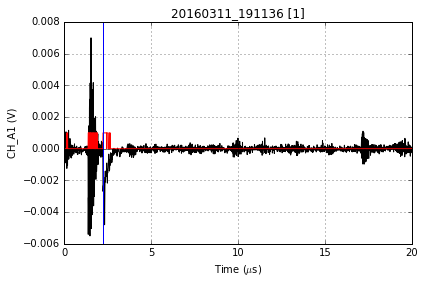

In [5]:
rep = 1
ydata = trace[rep]
xdata = np.arange(len(ydata)) * info['dt'] / 1e-6

#plot
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 'k')
# find where trace exceeds threshold
threshold = -ydata > min_level
ax.plot(xdata, np.int_(threshold)*min_level, '-r')
# first and last element must be False
threshold[0] = False
threshold[-1] = False
# find where True goes to False (pulse start/ stop)
rngs = np.where(np.diff(threshold))[0].reshape(-1, 2)
# find the pulses wider than the min_width
pulse = rngs[rngs[:,1]-rngs[:,0] > min_x]
#leading edge, width, and max value (assume negative)
trigger = pulse[:,0]
print "trigger : " + str(list(trigger * dt))
width = (pulse[:,1] - pulse[:,0]) * dt
print "width : " + str(list(width))
amp = [np.min(ydata[p[0]:p[1]]) for p in pulse]
print "amp : " + str(amp)
for trig in trigger:
    ax.axvline(x=xdata[trig])
    
#format
ax.set_ylabel( ftype + " (V)");
ax.set_xlabel(r"Time ($\mu$s)");
plt.title(rid + ' [' + str(rep) + ']');
plt.axhline(0, color='k', alpha=0.5)
plt.axvline(0, color='k', alpha=0.5)
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, ftype + "_" + str(squid) + "(" + str(rep) +").png")
plt.savefig(fileout, dpi=300)
plt.show()

In [6]:
# test against count.py
from oskar.count import find_triggers_1D

In [7]:
events = pd.DataFrame(find_triggers_1D(-ydata, dt, min_x, min_level))
events.head()

,trigger,width,amp
0,0.000002,2.100000e-07,0.004798
